In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split   

from keras.preprocessing.text import Tokenizer                   
from keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_excel('../Resources/Climate_change_links_2.xlsx')
data = df[["VideoID", "Effectiveness"]]

# clean data
data = data.loc[(data["Effectiveness"] == 1) | (data["Effectiveness"] == 2) | (data["Effectiveness"] == 3) | (data["Effectiveness"] == 4) | (data["Effectiveness"] == 5)]
data = data.reset_index()
del data["index"]

## Custom encoder
def custom_encoder(df):
    df.replace(to_replace = 1.0, value = 0, inplace=True)
    df.replace(to_replace = 2.0, value = 0, inplace=True)
    df.replace(to_replace = 4.0, value = 1, inplace=True)
    df.replace(to_replace = 5.0, value = 1, inplace=True)

custom_encoder(df['Effectiveness'])

data = df[["VideoID", "Effectiveness"]]
data = data[data["Effectiveness"] != 3]
data = data.loc[(data["Effectiveness"] == 0) | (data["Effectiveness"] == 1)]
data = data.reset_index()
del data["index"]
data

,VideoID,Effectiveness
0,pvuN_WvF1to,0.0
1,eRLJscAlk1M,1.0
2,VbiRNT_gWUQ,0.0
3,5scez5dqtAc,1.0
4,JDcro7dPqpA,0.0
...,...,...
131,IQpIVsxx014,0.0
132,JYZpxRy5Mfg,1.0
133,8DiWzvE52ZY,0.0
134,OwqIy8Ikv-c,0.0


In [3]:
## get documnets (pre-processd comments)
documents = []
for i in range(len(data)):
    VideoID = data["VideoID"][i]
    comment = pd.read_csv("../../NLP Preprocessing/03_Processed_Comments/"+VideoID+"/"+VideoID+"_all_words.csv")
    documents.append(list(comment["0"]))

In [4]:
## create two new columns of the pre-processed data in list and string form
data['cleaned'] = documents
data['cleaned_string'] = [' '.join(map(str, l)) for l in data['cleaned']]
data

,VideoID,Effectiveness,cleaned,cleaned_string
0,pvuN_WvF1to,0.0,"[clean, version, video, child, love, northeast...",clean version video child love northeast india...
1,eRLJscAlk1M,1.0,"[step, take, help, fight, climate, change, wel...",step take help fight climate change well equal...
2,VbiRNT_gWUQ,0.0,"[country, disappear, video, year, old, world, ...",country disappear video year old world map did...
3,5scez5dqtAc,1.0,"[im, watch, trump, biden, ha, already, start, ...",im watch trump biden ha already start process ...
4,JDcro7dPqpA,0.0,"[fun, fact, cow, belch, fart, adult, version, ...",fun fact cow belch fart adult version bill nye...
...,...,...,...,...
131,IQpIVsxx014,0.0,"[corporate, medium, fear, monger, earth, get, ...",corporate medium fear monger earth get flat wr...
132,JYZpxRy5Mfg,1.0,"[usually, consumer_NEG, say_NEG, though_NEG, s...",usually consumer_NEG say_NEG though_NEG suppor...
133,8DiWzvE52ZY,0.0,"[marios, leave, hand, doe, intro, impressive, ...",marios leave hand doe intro impressive today p...
134,OwqIy8Ikv-c,0.0,"[lie, interseting, isnt, group_NEG, consist_NE...",lie interseting isnt group_NEG consist_NEG com...


In [5]:
# split training and test set
sentences = data['cleaned_string'].values
y = data['Effectiveness'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# plot to see overfitting of neural networks
def plot_history(history, save_fig=False):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if save_fig:
        plt.savefig('History plot.png', bbox_inches = "tight")

#  Convolutional Neural Network (CNN)

In [7]:
# create tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # add 1 because of reserved 0 index

# pad data so that it has the same length
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [8]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed 
set_seed(2)

clear_session()

embedding_dim = 100

## create CNN model
model = Sequential()
# add embedding layer
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
# add convolutional layer
model.add(layers.Conv1D(128, 7, activation='relu'))
# add pooling layer
model.add(layers.GlobalMaxPooling1D())
# add dense layer with 10 neurons
model.add(layers.Dense(10, activation='softmax'))
# add output layer
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                     tf.keras.metrics.TruePositives(),
                                                                     tf.keras.metrics.TrueNegatives(),
                                                                     tf.keras.metrics.FalsePositives(),
                                                                     tf.keras.metrics.FalseNegatives(),   
                                                                     tf.keras.metrics.Precision(class_id=None),
                                                                     tf.keras.metrics.Recall()])

history = model.fit(X_train, y_train,
                    epochs=120,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=28)

In [9]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          41079600  
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 128)           89728     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 41,170,629
Trainable params: 41,170,629
Non-trainable params: 0
_________________________________________________________________


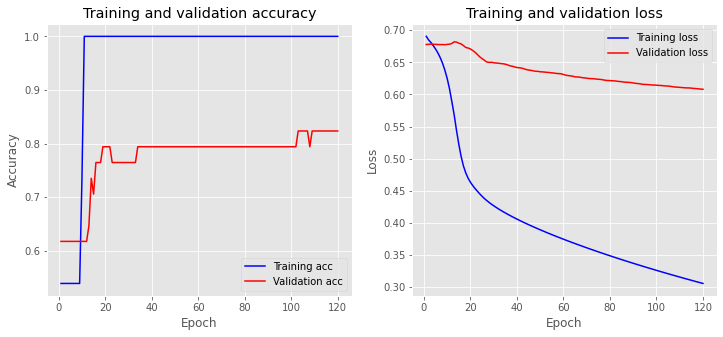

In [10]:
# plot accuracy and loss plots
plot_history(history)

In [11]:
# Evaluate
loss, accuracy, tp, tn, fp, fn, precision, recall = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy*100))

Testing Accuracy: 82.3529


In [12]:
print("Precision:  ", precision)
print("Recall:  ", recall)
print("Accuracy:  ", accuracy)
print("F1-Score:  ", (2*precision*recall)/(precision+recall))

Precision:   0.8888888955116272
Recall:   0.6153846383094788
Accuracy:   0.8235294222831726
F1-Score:   0.7272727454989408


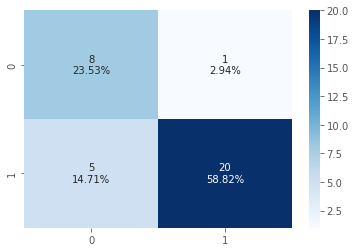

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# function to plot confusion matrix
def plot_conf_matrix(conf_matrix):
    group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    
# Creating confusion matrix
conf_matrix = np.array( [[tp, fp], 
                         [fn, tn]] )

plot_conf_matrix(conf_matrix)

# Using Bag of Words Vectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 1))
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [15]:
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed 
set_seed(2)

clear_session()

# Number of features
input_dim = X_train.shape[1]  

# create model with one hidden layer
model = Sequential()
model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=30,
                     verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=32)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy*100))

C:\Users\Jared\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Training Accuracy: 100.0000
Testing Accuracy:  73.5294


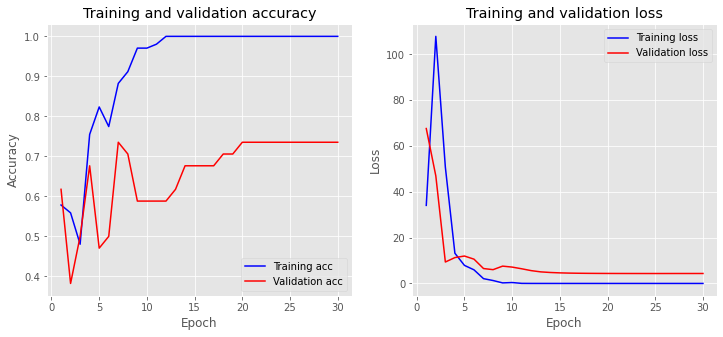

In [16]:
# plot accuracy and loss plots
plot_history(history)

# Hyperparameter Optimization

In [17]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [52]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# main settings
epochs = 20
embedding_dim = 50
maxlen = 100

sentences = data['cleaned_string'].values
y = data['Effectiveness'].values

# train-test split
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

# tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# add 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, verbose=1, n_iter=5)

grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)
grid_result.best_score_
grid_result.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.8min finished


({'vocab_size': 410796,
  'num_filters': 128,
  'maxlen': 100,
  'kernel_size': 7,
  'embedding_dim': 50},)